In [1]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [2]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [3]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [4]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                    # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

global_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up main dataframe with data from FIRST file
string = str(glob.glob(path)[0])                                 # in the folder.
global_tracks_df['Year'] = ""
global_tracks_df['Month'] = ""
year_month = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
for index,row in global_tracks_df.iterrows():
    global_tracks_df.loc[index, "Year"] = year_month[0][0]                   # file name, and sets up new columns called 'Year'
    global_tracks_df.loc[index, "Month"] = year_month[0][1]                  # and 'Month' with that info. 

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        temp_df['Year'] = ""
        temp_df['Month'] = ""
        year_month = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        for index,row in global_tracks_df.iterrows():
            temp_df[['Year']] = year_month[0][0]
            temp_df[['Month']] = year_month[0][1] 
        global_tracks_df = pd.concat([global_tracks_df,          # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.       
                                                 
global_tracks_df = global_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month

global_df = pd.DataFrame(global_tracks_df)                      # You should get 4,800 rows (24 months x 200 
global_df                                                       # tracks per month)

,Position,Track Name,Artist,Streams,URL,Year,Month
0,1,7 rings,Ariana Grande,71467874,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,33799389,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,01
2,3,Wow.,Post Malone,31165644,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01
3,4,"thank u, next",Ariana Grande,27672341,https://open.spotify.com/track/2rPE9A1vEgShuZx...,2019,01
4,5,Without Me,Halsey,27576694,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,01
...,...,...,...,...,...,...,...
195,196,POPSTAR (feat. Drake),DJ Khaled,6286261,https://open.spotify.com/track/6EDO9iiTtwNv6wa...,2020,12
196,197,My Kind Of Present,Meghan Trainor,6278993,https://open.spotify.com/track/2rkb8ijsPapKDME...,2020,12
197,198,Ride It,Regard,6264613,https://open.spotify.com/track/2tnVG71enUj33Ic...,2020,12
198,199,Jocelyn Flores,XXXTENTACION,6257992,https://open.spotify.com/track/7m9OqQk4RVRkw9J...,2020,12


In [5]:
# Get Track IDs

track_names = global_df['Track Name'].to_list()                   # Set up list of tacks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Lost in the Fire song ID : 2vXKRlJBXyOcvZYTdNeckS
Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
ZEZE (feat. Travis Scott & Offset) song ID : 0FZ4Dmg8jJJAPJnvBIzD9z
Saturday Nights song 

Love Lies (with Normani) song ID : 45Egmo7icyopuzJN0oMEdk
Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
bellyache song ID : 51NFxnQvaosfDDutk0tams
Familia (with Anuel Aa, feat. Bantu) - Spider-Man: Into the Spider-Verse song ID : 4Uy3kNxW2kB8AEoXljEcth
Thinking out Loud song ID : 34gCuhDGsG4bRPIf9bb02f
Praise The Lord (Da Shine) (feat. Skepta) song ID : 7ycWLEP1GsNjVvcjawXz3z
Jackie Chan song ID : 4kWO6O1BUXcZmaxitpVUwp
Jumpin on a Jet song ID : 1I3ZAmPmbFV78oNKnibOiW
So Close song ID : 7FjZU7XFs7P9jHI9Z0yRhK
PPP song ID : 14eTSBjCDBNyXv8taIyzKd
These Days (feat. Jess Glynne, Macklemore & Dan Caplen) song ID : 5CLGzJsGqhCEECcpnFQA8x
Calling My Spirit song ID : 2MShy1GSSgbmGUxADNIao5
Everybody Dies In Their Nightmares song ID : 3GVkPk8mqxz0itaAriG1L7
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
Ric Flair Drip (& Metro Boomin) song ID : 7sO5G9EABYOXQKNPNiE9NR
Lucky You (feat. Joyner Lucas) song ID : 60SdxE8apGAxMiRrpbmLY0
Africa song ID : 2374M0fQpWi3dLnB54

Nonstop song ID : 0TlLq3lA83rQOYtrqBqSct
Lost in the Fire song ID : 2vXKRlJBXyOcvZYTdNeckS
DNA song ID : 6HZILIRieu8S0iqY8kIKhj
bellyache song ID : 51NFxnQvaosfDDutk0tams
Too Good At Goodbyes song ID : 3VlbOrM6nYPprVvzBZllE5
No Stylist (feat. Drake) song ID : 04MLEeAMuV9IlHEsD8vF6A
BEBE song ID : 7D7EH7MGyNHWSkqrszerI1
Keanu Reeves song ID : 3PYx9Wte3jwb48V0wArMOy
This Feeling song ID : 4NBTZtAt1F13VvlSKe6KTl
Solo (feat. Demi Lovato) song ID : 6kPJZM97LwdG9QIsT7khp6
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Kiss and Make Up song ID : 7jr3iPu4O4bTCVwLMbdU2i
Ferrari song ID : 4mbb7hmfDR6M9cQaLdYSFd
Bones (feat. OneRepublic) song ID : 1pfgsjmxVZhoZpeDx6POKv
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
Last Hurrah song ID : 0i0wnv9UoFdZ5MfuFGQzMy
Vaina Loca song ID : 48zFZh27QU5qsrBjn4C2FA
Space Cadet (feat. Gunna) song ID : 1fewSx2d5KIZ04wsooEBOz
changes song ID : 7AFASza1mXqntmGtbxXprO
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
I Fall Apart song ID : 75ZvA4QfFiZvz

Price On My Head (feat. The Weeknd) song ID : 4hqOmrCCJKyiuwDexd8c2t
Say My Name song ID : 7H6ev70Weq6DdpZyyTmUXk
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Blackberry Sky song ID : 11rBlJlRoWNj69twOOki03
Confessions of a Dangerous Mind song ID : 6yIGZp1AaFBoDczu3b4hVU
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Splashin song ID : 3KLo7ByvjCNyBrfz5DZ2mO
Dancin (feat. Luvli) - Krono Remix song ID : 6WkJ2OK163XXS2oARUC9JM
Taste (feat. Offset) song ID : 5IaHrVsrferBYDm0bDyABy
Faucet Failure song ID : 1ThmUihH9dF8EV08ku5AXN
Soltera song ID : 1c0hsvHLELX6y8qymnpLKL
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Just You and I song ID : 03x2rVJRFUrvwlfxoHd9Mo
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Reggaeton song ID : 6yVkakCN460KOVol9ZazjH
no tea

Outta My Head (with John Mayer) song ID : 09oZ9eXQ2fo6YDrPzJqAoP
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
my strange addiction song ID : 3Tc57t9l2O8FwQZtQOvPXK
xanny song ID : 4QIo4oxwzzafcBWkKjDpXY
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy) song ID : 1WSGTYKLEpKfNQYYW5Oymt
Desconocidos song ID : 56f5qnyAlZdlz8wrUDA50h
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
Te Vi song ID : 059bcIhyc2SBwm6sw2AZzd
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
MONOPOLY (with Victoria Monét) song ID : 6tsOcBnaKgzK22yEiqRh8P
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Lucid Drea

bury a friend song ID : 4SSnFejRGlZikf02HLewEF
I THINK song ID : 2gTdDMpNxIRFSiu7HutMCg
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Boy With Luv (feat. Halsey) song ID : 5KawlOMHjWeUjQtnuRs22c
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Verte Ir song ID : 4lzxJ4jCuFDXXGkE1LmpKR
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Arcade song ID : 1Xi84slp6FryDSCbzq4UCD
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Suge song ID : 2gwkD6igEhQbDQegRCcdoB
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
RUNNING OU

Dancin (feat. Luvli) - Krono Remix song ID : 6WkJ2OK163XXS2oARUC9JM
idontwannabeyouanymore song ID : 41zXlQxzTi6cGAjpOXyLYH
Too Good At Goodbyes song ID : 3VlbOrM6nYPprVvzBZllE5
Juice song ID : 0k664IuFwVP557Gnx7RhIl
Falling Like The Stars song ID : 15xWRPHQMeqgdkGzInx3PY
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
bellyache song ID : 51NFxnQvaosfDDutk0tams
New Rules song ID : 2ekn2ttSfGqwhhate0LSR0
no tears left to cry song ID : 2qT1uLXPVPzGgFOx4jtEuo
Mo Bamba song ID : 1xzBco0xcoJEDXktl7Jxrr
Light It Up (with Tyga & Chris Brown) song ID : 4Q8aDd3H6LF8t4eY7So9O8
Gib Gas song ID : 7uwtPiqUx9Grd1bzhFEDk3
Swing song ID : 6hIOunhsLUT66KQgZV5dMD
Faucet Failure song ID : 1ThmUihH9dF8EV08ku5AXN
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
Rebota song ID : 2YRvdf9cdS88y1wB1WhKoE
Wake Up in the Sky song ID : 0QIjsbm2fh1cJ45XO9eGqq
Natural song ID : 2FY7b99s15jUpr

Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
Homicide (feat. Eminem) song ID : 7M2tXmeS15NAzEn7ABFeBg
Sixteen song ID : 3pJkBPHadRAxBBo484RipI
weR mAChT PaRA 2 song ID : 3curZWW2YQBZgaIYwkJp3L
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
Vossi Bop song ID : 44ZJ4hLD5onikKsVLQaILr
Amor Genuino song ID : 3xEozpt8pAptvpH69iJhOw
Desconocidos song ID : 56f5qnyAlZdlz8wrUDA50h
Photograph song ID : 1HNkqx9Ahdgi1Ixy2xkKkL
Lost In Japan song ID : 79esEXlqqmq0GPz0xQSZTV
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
All the Time song ID : 0USZx50eApN045zIIyjePN
idontwannabeyouanymore song ID : 41zXlQxzTi6cGAjpOXyLYH
Amanece song ID : 1LiN0Z98FkR1t0m8KmLcAH
Envy Me song ID : 7rvyVWja33WG9R97oeJAjx
One Kiss (with Dua Lipa) song ID : 7ef4DlsgrMEH11cDZd32M6
I Think I'm OKAY (with YUNGBLUD &

I Think I'm OKAY (with YUNGBLUD & Travis Barker) song ID : 2gTdDMpNxIRFSiu7HutMCg
I.F.L.Y. song ID : 4a6q8CR2hzLk2plDkSxkfD
Que Mas Pues - Remix song ID : 7fODjB7BrQTGqh0hogW6XD
BROWN SKIN GIRL song ID : 0B3FovCVaGKS5w1FTidEUP
The Archer song ID : 3pHkh7d0lzM2AldUtz2x37
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Nothing On You (feat. Paulo Londra & Dave) song ID : 2qRN7PWiHRLprw4FpDeI9N
i'm so tired... song ID : 4vjpLMyL3ZO6aphdYr8XYw
Si Supieras song ID : 3GnzoWqvd6XvSRjli1uCUC
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
Heaven song ID : 1HXy5I3HTWq8OvxCn0z7G7
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
comethru song ID : 18uwL0vNUanqZH0ro2QcOP
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Baby song I

Soon You’ll Get Better (feat. The Chicks) song ID : 4AYtqFyFbX0Xkc2wtcygTr
If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
I.F.L.Y. song ID : 4a6q8CR2hzLk2plDkSxkfD
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Teeth song ID : 26wLOs3ZuHJa2Ihhx6QIE6
Never Really Over song ID : 5PYQUBXc7NYeI1obMKSJK0
Good as Hell song ID : 6KgBpzTuTRPebChN0VTyzV
Daylight song ID : 6Ed1q0X8oSKSm4IIhiQbYg
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
bad guy (with Justin Bieber) song ID : 3yNZ5r3LKfdmjoS3gkhUCT
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Hot Girl Summer (feat. Nicki Minaj & Ty Dolla $ign) song ID : 5N1o6d8zGcSZSeMFkOUQOk
One Thing Right song ID : 4hPpVbbakQNv8YTHYaOJP4
It’s Nice To Have A Friend song ID : 1SmiQ65iSAbPto6gPFlBYm
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Si Se Da - Remix song ID :

Take What You Want (feat. Ozzy Osbourne & Travis Scott) song ID : 7CZyCXKG6d5ALeq41sLzbw
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Yo x Ti, Tu x Mi song ID : 7BlBVFwvbWvcwNcUarQmjk
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Liar song ID : 7LzouaWGFCy4tkXDOOnEyM
Enemies (feat. DaBaby) song ID : 0Xek5rqai2jcOWCYWJfVCF
Hollywood's Bleeding song ID : 7sWRlDoTDX8geTR8zzr2vt
Tutu song ID : 1nocRtwyNPVtGcIJqfgdzZ
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
boyfriend (with Social House) song ID : 0Ryd8975WihbObpp5cPW1t
Adicto (with Anuel AA & Ozuna) song ID : 3jbT1Y5MoPwEIpZndDDwVq
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
hot girl bummer song ID : 2mt1IqcFyY1zmYZT8Q3xw9
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
110 song ID : 2ncPzmrFyerSwG4XWy30JV
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkY

All of Me song ID : 3U4isOIWM3VvDubwSI3y7a
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
SLOW DANCING IN THE DARK song ID : 0rKtyWc8bvkriBthvHKY8d
Cuerpo en Venta song ID : 2B94bbI1a4LyBpK1439oP7
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
break up with your girlfriend, i'm bored song ID : 4kV4N9D1iKVxx1KLvtTpjS
La Boca - Remix song ID : 2EEmzqzM70CybVspgM7YRT
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
Que Mas Pues - Remix song ID : 7fODjB7BrQTGqh0hogW6XD
So Am I song ID : 2Xnv3GntqbBH1juvUYSpHG
EARFQUAKE song ID : 5hVghJ4KaYES3BFUATCYn0
Si Supieras song ID : 3GnzoWqvd6XvSRjli1uCUC
Photograph song ID : 1HNkqx9Ahdgi1Ixy2xkKkL
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
Something Just Like This song ID : 6RUKPb4LETWmmr3iAEQktW
Heartless (feat. Morgan Wallen) song ID : 3FU6urUVsgXa6RBuV2PdRk
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
Murder On My Mind song ID : 7eBqSVxrzQZtK2mmgRG6lC
Closer song ID 

Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Die For Me (feat. Future & Halsey) song ID : 2C6WXnmZ66tHhHlnvwePiK
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
Instagram song ID : 6z1kLsntE7FuzKZHZWrXYN
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Call You Mine song ID : 2oejEp50ZzPuQTQ6v54Evp
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Pop Out (feat. Lil Tjay) song ID : 6uFn47ACjqYkc0jADwEdj1
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
200 km/h song ID : 2PGA1AsJal6cyMNmKyE56q
Love Me song ID : 4e0FYxSROat25pH16zMTZI
2002 song ID : 2BgEsaKNfHUdlh97KmvFyo
comethru song ID : 18uwL0vNUanqZH0ro2QcOP
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
Goteo song ID : 634fDJYRCr5yzqfFWa9rfS
POPOPOP song ID :

Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
It's Beginning to Look a Lot like Christmas song ID : 5a1iz510sv2W9Dt1MvFd5R
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Que Calor (with J Balvin & El Alfa) song ID : 7j7q6tCfEIlTeZtGjuBDT6
Otro Trago - Remix song ID : 4bTZeO72FwMa6wKOiqoynL
QUE PRETENDES song ID : 25ZAibhr3bdlMCLmubZDVt
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Takeaway (feat. Lennon Stella) song ID : 16QhpULFOW9fE2yvXsJV6A
bad vibes forever song ID : 03eJ2DclFWXYU8GWgANdmZ
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Teeth song ID : 26wLOs3ZuHJa2Ihhx6QIE6
VALENTINO song ID : 6piAUJJQFD8oHDUr0b7l7q
Roller song ID : 5L95vS64rG1YMIFm1hLjyZ
Used To Love (with Dean Lewis) song ID : 7pWK1kMgHy5lNNiIfuRbkP
Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
Death song ID : 7eJMfftS33KTjuF7lTsMCx
Only Human song ID : 0DiDStADDVh3SvAsoJAFMk
The London (feat. J. Cole & Travis Scott) song

It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra) song ID : 2pXpURmn6zC5ZYDMms6fwa
Fantasias song ID : 6mAN61JH0dzyZpWslS11jy
Santa Claus Is Coming to Town song ID : 2QpN1ZVw8eJO5f7WcvUA1k
Blue Christmas song ID : 3QiAAp20rPC3dcAtKtMaqQ
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Santa Claus Is Coming To Town song ID : 2QpN1ZVw8eJO5f7WcvUA1k
Step Into Christmas song ID : 6sBWmE23q6xQHlnEZ8jYPT
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
No Idea song ID : 7AzlLxHn24DxjgQX73F9fU
My Only Wish (This Year) song ID : 0YWUHZPJVg4iujddsJDwhM
Christmas Lights song ID : 4fzyvSu73BhGvi96p2zwjL
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Run Rudolph Run - Single Version song ID : 2pnPe4pJtq7689i5ydzvJJ
Santa Claus Is Comin' to Town - Live at C.W. Post College, Greenvale, NY - December 1975 song ID : 6s2wpWPFPAg

everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
Señorita song ID : 0TK2YIli7K1leLovkQiNik
You should be sad song ID : 7lidXGPXPYLNThITAOTlkK
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
Sigues Con El song ID : 7sQKy5vlPQllr0k9IjYJv3
Suicidal song ID : 1iSqfoUFnQwV0QW1EfUit8
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Rare song ID : 7HMmFQsKsljwTw8bS7lu19
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
Good News song ID : 1DWZUa5Mzf2BwzpHtgbHPY
What A Man Gotta Do song ID : 4wNIkl5XGiAACjFBlDWuSd
What If I Told You That I Love You song ID : 74D7JUfU6HYeMx4bZhsHnG
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
BOP song ID : 6Ozh9Ok6h4Oi1wUSLtBseN
Say So song I

If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Otro Trago - Remix song ID : 4bTZeO72FwMa6wKOiqoynL
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
All of Me song ID : 3U4isOIWM3VvDubwSI3y7a
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
Takeaway song ID : 3g0mEQx3NTanacLseoP0Gw
I.F.L.Y. song ID : 4a6q8CR2hzLk2plDkSxkfD
Liar song ID : 7LzouaWGFCy4tkXDOOnEyM
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Look At Her Now song ID : 6ABeuUrilSljBZFfBC9fQL
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Bi Sonraki Hayatımda Gel song ID : 5SYkeNpjhJPFUMOP5TK8iw
Panini song ID : 1000nHvUdawXuUHgBod4Wv
You Need To Calm Down song ID : 6RRNNciQGZEXnqk8SQ9yv5
223's (feat. 9lokknine) song ID : 4sjiIpEv617LDXaidKioOI
idontwannabeyouanymore song ID : 41zXlQxzTi6cGAjpOXyLYH
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Legends song ID : 1Knctxx9vGZxpZfF66BIEa
SENTADÃO song ID : 4lKuzrdZrJuCAedbIs

Good as Hell (feat. Ariana Grande) song ID : 07Oz5StQ7GRoygNLaXs2pd
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
VIBEZ song ID : 0fySG6A6qLE8IvDpayb5bM
Lights Up song ID : 4jAIqgrPjKLTY9Gbez25Qb
GOODMORNINGTOKYO! song ID : 0Q2n5yzl2XRqYbV77tZNYp
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Go Stupid (feat. NLE Choppa & Mike WiLL Made-It) song ID : 0L8OsjxbagaGkJI0PezdRg
me & ur ghost song ID : 38KsRHYE10bG0paU78gL9r
Maniac song ID : 6KfoDhO4XUWSbnyKjNp9c4
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Tudo Ok song ID : 4HUZBG98TYbxSR9V1V2DWS
Quizas song ID : 5Id5B3dxJZhPcV9GzgYZZe
No Judgement song ID : 0pEiMdUEFUzgFSgIltZ9cw
Liberdade Provisória - Ao Vivo song ID : 4Y0gR2tYML083T6b2vhJrn
Trampoline (with ZAYN) song ID : 1iQDltZqI7BXnHrFy4Qo1k
Eastside

Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Suicidal song ID : 1iSqfoUFnQwV0QW1EfUit8
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
China song ID : 2ksOAxtIxY8yElEWw8RhgK
In Your Eyes (feat. Alida) song ID : 61ZM92T2zaXIVsqncThQzC
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Maniac song ID : 6KfoDhO4XUWSbnyKjNp9c4
A Tu Merced song ID : 4r9jkMEnArtWGH2rL2FZl0
I Love Me song ID : 2IHLaN6wwYKQ3S24NsQqpA
Muévelo song ID : 4VgYtXCVJ7IbWAZ5ryfvEQ
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
BOP song ID : 6Ozh9Ok6h4Oi1wUSLtBseN
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
Me Gusta song ID : 5Xhqh4lwJPtMUTsdBztN1a
WANNABE song ID : 1Je1IMUlBXcx1Fz0WE7oPT
Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Bandit (with YoungBoy Never Broke Again) song ID : 6Gg1gjgKi2AK4e0qzsR7sd
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Ransom 

10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
PICK UP (feat. Quavo) song ID : 5gNOINI5dXZVom2b36LMOd
Selfish song ID : 2xbI8Vmyv3TkpTdywpPyNw
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
P2 song ID : 3kW4z2pIj5VY5fLjBrMRL5
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Elegí (feat. Dímelo Flow) song ID : 50ZC4PM7hywH27RcCfViau
Know Your Worth song ID : 0TrPqhAMoaKUFLR7iYDokf
After Hours song ID : 2p8IUWQDrpjuFltbdgLOag
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Moral of the Story song ID : 2nC3QhMI9reBIOWutbU3Tj
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Sigues Con El song ID : 7sQKy5vlPQllr0k9IjYJv3
La Santa song ID : 69vlMrzHwATKzupwNcUPyK
In Your Eyes (feat. Alida) song ID : 61ZM92T2zaXIVsqncThQzC
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp


Memories song ID : 2b8fOow8UzyDFAE27YhOZM
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Rojo song ID : 4zrkgzHl26rkCADbWe1PKw
Señorita song ID : 0TK2YIli7K1leLovkQiNik
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Righteous song ID : 5dOxHHMOFAbG3VH23t0xNm
Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
Favorito song ID : 0Snbzbd74RLfL0i4nn1vU5
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Daechwita song ID : 0H4ugk6rhnXmTl47ayy9O5
Savage song ID : 55CHeLEfn5iJ0IIkgaa4si
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Walk Em Down (feat. Roddy Ricch) song ID : 4cSSL3YafYjM3yjgFO1vJg
PORFA song ID : 5CGRlMZ2SIEkgpnrMqoHnY
Chicago Freestyle (feat. Giveon) song ID : 4wVOKKEHUJxHCFFNUWDn0B
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Godzilla (feat. Juice WRLD) song ID : 7FIWs0pqAYbP91WWM0vlTQ
Skecher

Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
THE SCOTTS song ID : 39Yp9wwQiSRIDOvrVg7mbk
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
GOOBA song ID : 4NhDYoQTYCdWHTvlbGVgwo
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Sunday Best song ID : 1Cv1YLb4q0RzL6pybtaMLo
Savage Remix (feat. Beyoncé) song ID : 5v4GgrXPMghOnBBLmveLac
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
Say So song ID : 3Dv1eDb0MEgF93GpLXlucZ
La Jeepeta - Remix song ID : 1mohfLaTJtB2RplHLQVM70
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Tusa song ID : 7k4t7uLgtOxPwT

Like That (feat. Gucci Mane) song ID : 4EivmOT13NMpNSfTKn9p4s
Lights Up song ID : 4jAIqgrPjKLTY9Gbez25Qb
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Riptide song ID : 3JvrhDOgAt6p7K8mDyZwRd
Don't Stop Believin' song ID : 4bHsxqR3GMrXTxEPLuK5ue
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Wake Me Up song ID : 0nrRP2bk19rLc0orkWPQk2
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
I'm Yours song ID : 1EzrEOXmMH3G43AXT1y7pA
Na Raba Toma Tapão song ID : 0AGS6ZRgzobrazmCi6pYMe
La Santa song ID : 69vlMrzHwATKzupwNcUPyK
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Make You Mine song ID : 5iFwAOB2TFkPJk8sMlxP8g
Every Breath You Take song ID : 1JSTJqkT5qHq8MDJnJ

Alane song ID : 2u6Jm2klS4yvAlbSHlxUwI
El Efecto song ID : 4SJHHpKhcuXwDsCsPqshXj
Be Like That - feat. Swae Lee & Khalid song ID : 5f1joOtoMeyppIcJGZQvqJ
Screw Juice song ID : 4F6YLjakjqWFTgC5qfEwPQ
Amarillo song ID : 6OsbuHK5jQ626AAius3Cqx
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Ay, DiOs Mío! song ID : 63qxoiGA8qHGXoDzzvZ704
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
El Mismo Aire - con Pablo Alborán song ID : 5EbtodsuLbxrFDH6j5avVS
Sour Candy (with BLACKPINK) song ID : 1IWNylpZ477gIVUDpJL66u
PAM song ID : 0eeKDrQxjqNl5bX5VCHDcn
Only You Freestyle song ID : 4OENnoidV0h8gJV6bhrw7r
Past Life (with Selena Gomez) song ID : 4P6IttK2PRBjyr3fm0pP7t
Jangueo song ID : 1bRpSCFv6P2OUhciByeRYR
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
I Want It song ID : 2SVx3uds6jTWALFxevIWMA
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Savage song ID : 55CHeLEfn5iJ0IIkgaa4si
Skecher

my ex's best friend (with blackbear) song ID : 7kDUspsoYfLkWnZR7qwHZl
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Rojo song ID : 4zrkgzHl26rkCADbWe1PKw
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Bande organisée song ID : 205HNJ73cgpC0LAOnuQiWT
Yo Perreo Sola song ID : 0SqqAgdovOE24BzxIClpjw
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
Nobody's Love song ID : 3kwgqoBqTwoAH4nT29TYrq
GOOBA song ID : 4NhDYoQTYCdWHTvlbGVgwo
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
Play Date song ID : 4DpNNXFMMxQEKl7r0ykkWA
the 1 song ID : 0Jlcvv8IykzHaSmj49uNW8
Tak Tiki Tak song ID : 7gwwt1IaAWwmB7af0AcuBM
Hate The Other Side (with Marshmello & The Kid Laroi) song ID : 0ada5XsQGLPUVbmTCkAP49
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Parce (feat. Justin Quiles) song ID : 4RJz8NfIe09gpKMiRUWKhJ
Caramelo - Remix song ID : 2uu2aGqA2UblCg581Q7l1g
Conversation

What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Despeinada song ID : 0JAZWvvqttGFm4UMDsPQXC
Still Don't Know My Name song ID : 6N22FZs2ZhPBYi3b9XPajV
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
my ex's best friend (with blackbear) song ID : 7kDUspsoYfLkWnZR7qwHZl
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Ayer Me Llamó Mi Ex (feat. Lenny Santos) song ID : 6C6mUonH6MNdSg5pw7kOc9
Mamichula - con Nicki Nicole song ID : 0TUW9faHNaBmi89wsYGp9y
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
SICKO MODE song I

La Tóxica song ID : 15OjBeqNX3bShsGYQbteRv
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Vida de Rico song ID : 73nAK3HgQK8dak83Y2WQ8F
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
La Curiosidad song ID : 4HYDUMY0xSpeBr0AMY9cUz
UN DIA (ONE DAY) (Feat. Tainy) song ID : 0EhpEsp4L0oRGM0vmeaN5e
Forever After All song ID : 6IBcOGPsniK3Pso1wHIhew
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
Se Te Nota (with Guaynaa) song ID : 11EnQRgRMJwMAesfkB5pnu
Ice Cream (with Selena Gomez) song ID : 4JUPEh2DVSXFGExu4Uxevz
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Midnight Sky song ID : 27ycaQnQAxaPiyeg3nr2aB
Lovesick Girls song ID : 4Ws314Ylb27BVsvlZOy30C
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Una Locura song ID : 5y7DaS3jAc9eZzcSOoUIwU
Ay, DiOs Mío! song ID : 63qxoiGA8qHGXoDzzvZ704
Despeinada song ID : 0JAZWvvqttGFm4UM

Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
Star Shopping song ID : 30bqVoKjX479ab90a8Pafp
The Less I Know The Better song ID : 6K4t31amVTZDgR3sKmwUJJ
Mamichula - con Nicki Nicole song ID : 0TUW9faHNaBmi89wsYGp9y
Take Me To Church song ID : 1CS7Sd1u5tWkstBhpssyjP
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Photograph song ID : 1HNkqx9Ahdgi1Ixy2xkKkL
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Let Her Go song ID : 0JmiBCpWc1IAc0et7Xm7FL
Play Date song ID : 4DpNNXFMMxQEKl7r0ykkWA
Moonwalking in Calabasas (feat. Blueface) - Remix song ID : 7o4gBbTM6UBLkOYPw9xMCz
Lose Somebody song ID : 7xbWAw3LMgRMn4omR5yVn3
Someone Like You song ID : 1zwMYTA5nlNjZxYrvBB2pV
SLOW DANCING IN THE DARK song ID : 0rKtyWc8bvkriBthvHKY8d
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Something Just Like This song ID : 6RUKPb4LETWmmr3iAEQktW
DÁKITI song ID : 47EiUVwUp4C9fGccaPuUCS
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
positions song ID : 35mvY5S1H3J2QZyna3TFe0
Life Goes On song ID : 249gnXrbfmV8N

Go Crazy song ID : 1IIKrJVP1C9N7iPtG6eOsK
Martin & Gina song ID : 1VLtjHwRWOVJiE5Py7JxoQ
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Feliz Navidad song ID : 0oPdaY4dXtc3ZsaG17V972
motive (with Doja Cat) song ID : 5GkQIP5mWPi4KZLLXeuFTT
Electric Love song ID : 2GiJYvgVaD2HtM8GqD9EgQ
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Polvo song ID : 68mrW6gXHgupgSiDHgaDi5
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Holly Jolly Christmas song ID : 5PuKlCjfEVIXl0ZBp5ZW9g
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
At My Worst song ID : 0ri0Han4IRJhzvERHOZTMr
Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet) song ID : 4kKdvXD0ez7jp1296JmAts
Daddy Issues song ID : 5E30LdtzQTGqRvNd7l6kG5
The Woo (feat. 50 Cent & Roddy Ricch) song ID : 1H7KnK26kc1YyellpbINEn
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
Tik Tok (feat. Marracash & Guè Pequeno) song ID : 3tkYK45AZC0PqJ7MSe6IyJ
All of Me song ID : 3U4i

no body, no crime (feat. HAIM) song ID : 3RaT22zZsxVYxxKR7TAaYF
Body song ID : 0A1hoCfMLkiAgvhWkkucJa
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Parce (feat. Justin Quiles) song ID : 4RJz8NfIe09gpKMiRUWKhJ
Christmas Without You song ID : 1QLZKzC2pjP4ySf4ALrNhm
Put Your Records On song ID : 6AGOKlMZWLCaEJGnaROtF9
You Make It Feel Like Christmas (feat. Blake Shelton) song ID : 2OQ6a4CfUeYskpTTgyawyJ
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Gnat song ID : 6cS9PmLky2NhLOhpIsUlow
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
SO DONE song ID : 5psEZhQu6lukjhavJo4AbC
Joy To The World song ID : 2ymeOsYijJz09LfKw3yM2x
Nathy Peluso: Bzrp Music Sessions, Vol. 36 song ID : 78SeXVRJ7KCqVmOwTiFjnI
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Tusa

TIP: for this next section, add an "output_files" subfolder to export into. 

In [6]:
# Add Track IDs to dataframe

global_df['Track ID'] = track_ids                  # Add new column with track IDs

In [7]:
# Drop empty songs and export dataframe to csv to back it up

clean_global_df = global_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_global_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [8]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

clean_global_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

clean_global_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID
0,1,7 rings,Ariana Grande,71467874,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,6ocbgoVGwYJhOv1GgI9NsF
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,33799389,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,3KkXRkHbMCARz0aVfEt68P
2,3,Wow.,Post Malone,31165644,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,7xQAfvXzm3AkraOtGPWIZg
3,4,"thank u, next",Ariana Grande,27672341,https://open.spotify.com/track/2rPE9A1vEgShuZx...,2019,1,3e9HZxeyfWwjeyPAMmWSSQ
4,5,Without Me,Halsey,27576694,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,7lQ8MOhq6IN2w8EYcFNSUk
...,...,...,...,...,...,...,...,...
4780,196,POPSTAR (feat. Drake),DJ Khaled,6286261,https://open.spotify.com/track/6EDO9iiTtwNv6wa...,2020,12,6EDO9iiTtwNv6waLwa1UUq
4781,197,My Kind Of Present,Meghan Trainor,6278993,https://open.spotify.com/track/2rkb8ijsPapKDME...,2020,12,2rkb8ijsPapKDMEh0cSe8I
4782,198,Ride It,Regard,6264613,https://open.spotify.com/track/2tnVG71enUj33Ic...,2020,12,2tnVG71enUj33Ic2nFN6kZ
4783,199,Jocelyn Flores,XXXTENTACION,6257992,https://open.spotify.com/track/7m9OqQk4RVRkw9J...,2020,12,7m9OqQk4RVRkw9JJdeAw96


In [9]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []

for track in clean_global_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)


6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
4w8niZpiMy6qz1mntFA5uM Valence Score: 0.617
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
2vXKRlJBXyOcvZYTdNeckS Valence Score: 0.166
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
78QR3Wp35dqAhFEc2qAGjE Valence Score: 0.389
5JEx7HbmvHQQswJCsoo9rA Valence Sco

2ijef6ni2amuunRoKTlgww Valence Score: 0.82
5Gu0PDLN4YJeW75PpBSg9p Valence Score: 0.742
45h4w81P5iJJTSeR0jJUQ8 Valence Score: 0.232
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
3GCdLUSnKSMJhs4Tj6CV3s Valence Score: 0.552
7uzmGiiJyRfuViKKK3lVmR Valence Score: 0.717
1h9P5WJwyvK8OB7O2YiXgp Valence Score: 0.726
7iTTQvztpfrDneVSX9IGBD Valence Score: 0.643
7floNISpH8VF4z4459Qo18 Valence Score: 0.349
2j5hsQvApottzvTn4pFJWF Valence Score: 0.419
33gwZOGJWEZ7dRWPqPxBEZ Valence Score: 0.325
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
7DnAm9FOTWE3cUvso43HhI Valence Sc

5OCJzvD7sykQEKHH7qAC3C Valence Score: 0.268
1riyn0cmi87k1YsBn4Lfwk Valence Score: 0.783
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
4EAV2cKiqKP5UPZmY6dejk Valence Score: 0.422
7vGuf3Y35N4wmASOKLUVVU Valence Score: 0.286
6mQLN3zRtAp6ovjusyYKrV Valence Score: 0.571
1HNkqx9Ahdgi1Ixy2xkKkL Valence Score: 0.201
4S8d14HvHb70ImctNgVzQQ Valence Score: 0.329
3oL3s33HbtOQi0bWP5lYvN Valence Score: 0.418
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
7GX5flRQZVHRAGd6B4TmDO Valence Score: 0.401
7iDa6hUg2VgEL1o1HjmfBn Valence Score: 0.579
58oryymPZNdtS2z8Une6NJ Valence Score: 0.488
04ZTP5KsCypmtCmQg5tH9R Valence Score: 0.216
2XXMDz7SPZ4mSFN1PXfHUy Valence Score: 0.295
1Spmq0UazGU6ovMIlGldZX Valence Score: 0.922
7pdF27mSDuPWhppnHAmWHa Valence Score: 0.369
7ygpwy2qP3NbrxVkHvUhXY Valence Score: 0.434
7KXjTSCq5nL1LoYtL7XAwS Valence Score: 0.421
2374M0fQpWi3dLnB54qaLX Valence Score: 0.732
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
6vWEAOUSxohKxhp0K1BsxL Valence Score: 0.352
1EzrEOXmMH3G43AXT1y7pA Valence Sc

2ktoFujjJtantyMoVdBJlX Valence Score: 0.856
2jQiSYrwJehQAcuaaQrXnS Valence Score: 0.0911
37eGbhE1xVFSvcKkqGb6i1 Valence Score: 0.598
2ekn2ttSfGqwhhate0LSR0 Valence Score: 0.608
3ao3OVxHlb3C08vAaApUlm Valence Score: 0.913
54flyrjcdnQdco7300avMJ Valence Score: 0.473
716eVtciaJCtTcaknS3QXr Valence Score: 0.298
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
3V8UKqhEK5zBkBb6d6ub8i Valence Score: 0.442
0Jr4zQh5i3vrKFEcXrhhxl Valence Score: 0.331
10Igtw8bSDyyFs7KIsKngZ Valence Score: 0.755
1HNkqx9Ahdgi1Ixy2xkKkL Valence Score: 0.201
448hSkxDU1sUQQauBWZVcC Valence Score: 0.651
48zFZh27QU5qsrBjn4C2FA Valence Score: 0.555
5J5CpT6bgE6KYKk23jgp9W Valence Score: 0.431
6epn3r7S14KUqlReYr77hA Valence Score: 0.535
5wujBwqG7INdStqGd4tRMX Valence Score: 0.845
4mGdjNMo0RonTlOEb7cYg4 Valence Score: 0.233
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
1Kjer1JoWuJGNwGV6Pbgv1 Valence Score: 0.695
4TWflhgevIGo448fWc6mQq Valence Score: 0.527
7GX5flRQZVHRAGd6B4TmDO Valence Score: 0.401
7jr3iPu4O4bTCVwLMbdU2i Valence 

2FY7b99s15jUprqC0M5NCT Valence Score: 0.22
3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 0.492
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
1rfofaqEpACxVEHIZBJe6W Valence Score: 0.394
4VUwkH455At9kENOfzTqmF Valence Score: 0.249
0pSBuHjILhNEo55xK1zrRt Valence Score: 0.789
0eeeyCAGnGZInPtpkdYiPa Valence Score: 0.241
6ya8ejoKgw906Y8LWclqrp Valence Score: 0.702
2G7V7zsVDxg1yRsu7Ew9RJ Valence Score: 0.35
2jQiSYrwJehQAcuaaQrXnS Valence Score: 0.0911
6N22Yl2nHPnksP1hu3mxJE Valence Score: 0.164
4pCEIQ6wBVuaJdER5bALtO Valence Score: 0.258
1rCcsYnmqbMYdkG7kS9GC5 Valence Score: 0.266
4NBTZtAt1F13VvlSKe6KTl Valence Score: 0.449
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
7qLnSuxwLNlcapat8OCWZp Valence Score: 0.715
38SKB7UfhL6Sd6Joxex5yK Valence Score: 0.409
1HNkqx9Ahdgi1Ixy2xkKkL Valence Score: 0.201
6RUKPb4LETWmmr3iAEQktW Valence Score: 0.446
10Igtw8bSDyyFs7KIsKngZ Valence Score: 0.755
6yVkakCN460KOVol9ZazjH Valence Sc

3f5lA8nnc4YYF1qf78WpHw Valence Score: 0.697
5IaHrVsrferBYDm0bDyABy Valence Score: 0.342
7m9OqQk4RVRkw9JJdeAw96 Valence Score: 0.437
6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
1kK6DwzyXJSp58u5HYWwuD Valence Score: 0.131
6vWEAOUSxohKxhp0K1BsxL Valence Score: 0.352
6Dq8FZrvx9S28iyaKSwn9x Valence Score: 0.61
4cbdPT6uaBOgOQe3fLMofl Valence Score: 0.172
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
1zB4vmk8tFRmM9UULNzbLB Valence Score: 0.288
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
5N5k9nd479b1xpDZ4usjrg Valence Score: 0.486
2tOOcDDYkh0PSjr6GwPEAJ Valence Score: 0.771
7hDVYcQq6MxkdJGweuCtl9 Valence Score: 0.169
3swc6WTsr7rl9DqQKQA55C Valence Score: 0.459
6CcJMwBtXByIz4zQLzFkKc Valence Score: 0.12
2JeoFOJjS1x2mN7efAMS24 Valence Score: 0.153
79esEXlqqmq0GPz0xQSZTV Valence Score: 0.425
22oEJW6r2rMb9z4IntfyEa Valence Score: 0.58
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
6N22Yl2nHPnksP1hu3mxJE Valence Score: 0.164
2t8yVaLvJ0RenpXUIAC52d Valence Scor

5IaHrVsrferBYDm0bDyABy Valence Score: 0.342
2FqqVHvC4eKrsk97vpMRid Valence Score: 0.538
0BrDfbNc3HiIHPGfTT8DRc Valence Score: 0.593
0UQwlF2pRkr1lMN6kNNUj3 Valence Score: 0.76
2RSHsoi04658QL5xgQVov3 Valence Score: 0.0827
78QR3Wp35dqAhFEc2qAGjE Valence Score: 0.389
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
4gMC0JNQITGa8wfTFsPu3f Valence Score: 0.249
3Ol2xnObFdKV9pmRD2t9x8 Valence Score: 0.536
7M2tXmeS15NAzEn7ABFeBg Valence Score: 0.77
3pJkBPHadRAxBBo484RipI Valence Score: 0.425
3curZWW2YQBZgaIYwkJp3L Valence Score: 0.949
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
4ZLzoOkj0MPWrTLvooIuaa Valence Score: 0.0895
2rbDhOo9Fh61Bbu23T2qCk Valence Score: 0.296
44ZJ4hLD5onikKsVLQaILr Valence Score: 0.428
3xEozpt8pAptvpH69iJhOw Valence Score: 0.347
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
1HNkqx9Ahdgi1Ixy2xkKkL Valence Score: 0.201
79esEXlqqmq0GPz0xQSZTV Valence Score: 0.425
6GG73Jik4jUlQCkKg9JuGO Valence Score: 0.903
1rfofaqEpACxVEHIZBJe6W Valence S

1wJRveJZLSb1rjhnUHQiv6 Valence Score: 0.434
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
0UQwlF2pRkr1lMN6kNNUj3 Valence Score: 0.76
67XyC1GdSkKb9sbRRkUDXS Valence Score: 0.568
2Xnv3GntqbBH1juvUYSpHG Valence Score: 0.628
0E9ZjEAyAwOXZ7wJC0PD33 Valence Score: 0.163
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
2zjGJ0dChMR0KxBZS15aqo Valence Score: 0.312
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
6K5BsR04ijf3FHNzjbaagD Valence Score: 0.774
3j84U36KvLeXNDPv4t5pI8 Valence Score: 0.137
7hQJA50XrCWABAu5v6QZ4i Valence Score: 0.601
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
3loy88Lp5qoTHhL8GhRfVZ Valence Score: 0.434
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
68Vm2W4oURsPV3121vUZgB Valence Score: 0.257
0Rx0DJI556Ix5gBny6EWmn Valence Score: 0.591
1iWHabUgUuuKLBa0TzTHfk Valence Sco

4SSnFejRGlZikf02HLewEF Valence Score: 0.196
6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
7anSoGdgtmJTAPZBzcPhO6 Valence Score: 0.688
4Clmg1g8n2yBYG13Z1oSdG Valence Score: 0.556
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
2KKijf6Ett4kmVNJze2roh Valence Score: 0.811
3sgGmPQD2J6aQduN36RDBO Valence Score: 0.515
1q8NdCAQ9QUjpYiqzdd3mv Valence Score: 0.883
5L95vS64rG1YMIFm1hLjyZ Valence Score: 0.279
7g8YaUQABMal0zWe7a2ijz Valence Score: 0.727
6ImEBuxsbuTowuHmg3Z2FO Valence Score: 0.607
6PYnUsNEpYC7A4BS2sjw3L Valence Score: 0.556
5kBYMymc2d3h164QqEHwRL Valence Score: 0.441
5pAbCxt9e3f81lOmjIXwzd Valence Score: 0.635
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
6V1bu6o1Yo5ZXnsCJU8Ovk Valence Score: 0.448
2oejEp50ZzPuQTQ6v54Evp Valence Score: 0.522
1D2Aldrksl9yWWCIPOeDzy Valence Score: 0.52
3GnzoWqvd6XvSRjli1uCUC Valence Score: 0.623
2qxmye6gAegTMjLKEBoR3d Valence Score: 0.483
67XyC1GdSkKb9sbRRkUDXS Valence Score: 0.568
2S93hylQBYLndMnaJuso8S Valence Score: 0.391
1kMUGCt7XLDc5Q64Vl0H8S Valence Sc

3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
6K5BsR04ijf3FHNzjbaagD Valence Score: 0.774
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
7j7q6tCfEIlTeZtGjuBDT6 Valence Score: 0.46
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
2Rk4JlNc2TPmZe2af99d45 Valence Score: 0.728
5Id5B3dxJZhPcV9GzgYZZe Valence Score: 0.677
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
2WsuSYJNXGKXVYkHPnq2yp Valence Score: 0.45
6z1kLsntE7FuzKZHZWrXYN Valence Score: 0.219
4xhWfr0tyA7BGL7eXo8KnV Valence Score: 0.468
1hrHUEYoVBC1hNCXkX7tIA Valence Score: 0.454
5N1o6d8zGcSZSeMFkOUQOk Valence Score: 0.57
59s0s39NFWScuHDbHytI14 Valence Score: 0.896
4e0FYxSROat25pH16zMTZI Valence Score: 0.803
0s26En1JoJhVj32vizElpA Valence Score: 0.246
1ckLp8lCl8LipXI0ypX72m Valence Score: 0.368
2qxmye6gAegTMjLKEBoR3d Valence Score: 0.483
4lzxJ4jCuFDXXGkE1LmpKR Valence Score: 0.553
6uFn47ACjqYkc0jADwEdj1 Valence Score: 0.261
1YscJ7yVTlFxW3eF6pv5ba Valence Score: 0.57
1GeNui6m825V8jP4uKiIaH Valence Score

7iHHxY2NLlJRAmlAmC4ahQ Valence Score: 0.726
1dGr1c8CrMLDpV6mPbImSI Valence Score: 0.453
6LsAAHotRLMOHfCsSfYCsz Valence Score: 0.864
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
25ZAibhr3bdlMCLmubZDVt Valence Score: 0.939
0s26En1JoJhVj32vizElpA Valence Score: 0.246
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
7KbF6AdprOXEEHlsq11Z6d Valence Score: 0.68
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
2qG5sZ7Si6sdK74qLxedYM Valence Score: 0.746
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
0RLLvYBopDwooCyvnTwgYu Valence Score: 0.321
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
6TqXcAFInzjp0bODyvrWEq Valence Score: 0.346
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
6UjZ2Yx2g2a52XxiA8ONxZ Valence Score: 0.258
1ndyl3wJCFs872XZ3ztPk6 Valence Score: 0.831
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
6RRNNciQGZEXnqk8SQ9yv5 Valence Score: 0.714
1tNJrcVe6gwLEiZCtprs1u Valence Score: 0.877
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
1BxpzDQKBQQijR4geXALKC Valence Sc

6LcauUZjF1eXQrgqMUecHX Valence Score: 0.714
5ry2OE6R2zPQFDO85XkgRb Valence Score: 0.101
7iHHxY2NLlJRAmlAmC4ahQ Valence Score: 0.726
03T4ttRCiLXST6MZjeMwmR Valence Score: 0.282
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
3cphb8kdsjElYR7r5icK3H Valence Score: 0.392
598yNsG1JFrGd4n2kMoz7F Valence Score: 0.43
2ktxr00GpTtbMNeBjNeY8D Valence Score: 0.874
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
1c0hsvHLELX6y8qymnpLKL Valence Score: 0.799
1000nHvUdawXuUHgBod4Wv Valence Score: 0.475
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
4sWuPniHClkInYAnzXAYUF Valence Score: 0.761
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
3Z0oQ8r78OUaHvGPiDBR3W Valence Score: 0.274
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
3QzAOrNlsabgbMwlZt7TAY Valence Score: 0.244
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
0fySG6A6qLE8IvDpayb5bM Valence Sc

7AzlLxHn24DxjgQX73F9fU Valence Score: 0.35
0YWUHZPJVg4iujddsJDwhM Valence Score: 0.702
4fzyvSu73BhGvi96p2zwjL Valence Score: 0.237
0fea68AdmYNygeTGI4RC18 Valence Score: 0.429
2pnPe4pJtq7689i5ydzvJJ Valence Score: 0.957
6s2wpWPFPAgKg2LXxi1Oee Valence Score: 0.407
6LcauUZjF1eXQrgqMUecHX Valence Score: 0.714
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
1OjmlSFuzYflWjSMTCyTJv Valence Score: 0.61
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
2TH65lNHgvLxCKXM3apjxI Valence Score: 0.244
4jAIqgrPjKLTY9Gbez25Qb Valence Score: 0.27
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
1vZKP9XURuqMp1SpXGnoyb Valence Score: 0.468
1N1ZpYUJc9fwrqk53FGgWv Valence Score: 0.724
4R8BJggjosTswLxtkw8V7P Valence Score: 0.58
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
1vZKP9XURuqMp1SpXGnoyb Valence Score: 0.468
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
2pWOMNQJW3g2zmGjP0Vkb0 Valence Score

07KXEDMj78x68D884wgVEm Valence Score: 0.511
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 0.604
2pWOMNQJW3g2zmGjP0Vkb0 Valence Score: 0.662
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
0VSzREd1OjEWJ9tXoFHRQH Valence Score: 0.393
4R8BJggjosTswLxtkw8V7P Valence Score: 0.58
0fea68AdmYNygeTGI4RC18 Valence Score: 0.429
2FvD20Z8aoWIePi7PoN8sG Valence Score: 0.542
2Ec33AVlkTTq8BHFgBTdQs Valence Score: 0.296
1ToprX3cpBiXoAe5eNSk74 Valence Score: 0.115
2TH65lNHgvLxCKXM3apjxI Valence Score: 0.244
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
3jbT1Y5MoPwEIpZndDDwVq Valence Score: 0.623
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
1iQDltZqI7BXnHrFy4Qo1k Valence Score: 0.498
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 0.163
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 0.397
0fySG6A6qLE8IvDpayb5bM Valence Sco

6XXYdF6pJR1K3wKvuxmu7n Valence Score: 0.392
5eEQCfq7MXQr6aHLNRUZLs Valence Score: 0.51
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
1iSqfoUFnQwV0QW1EfUit8 Valence Score: 0.235
2nC3QhMI9reBIOWutbU3Tj Valence Score: 0.265
0ono6UCNVZ1XqOm6j78Blu Valence Score: 0.86
3bkkMZEAhx7rTVz1C0itRQ Valence Score: 0.49
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
6mAN61JH0dzyZpWslS11jy Valence Score: 0.788
4VgYtXCVJ7IbWAZ5ryfvEQ Valence Score: 0.919
4wNIkl5XGiAACjFBlDWuSd Valence Score: 0.324
3op7HNwLli54MBjFGzIlZO Valence Score: 0.485
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
1GDTbEW4AqIgEzGbWxr19n Valence Score: 0.503
74D7JUfU6HYeMx4bZhsHnG Valence Score: 0.224
4vTgx6h4seHvkuFh84JXYP Valence Score: 0.664
2ePtv8MlBO9nuuXABqAfEX Valence Score: 0.368
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
6Ozh9Ok6h4Oi1wUSLtBseN Valence Score: 0.836
0TrPqhAMoaKUFLR7iYDokf Valence Score: 0.508
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
2wrJq5XKLnmhRXHIAf9xBa Valence Scor

3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
0oMtyJ3w2mCkztYRykM8sg Valence Score: 0.781
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
3WlbeuhfRSqU7ylK2Ui5U7 Valence Score: 0.243
3orEOtd8CPL8GFlpRpKuoE Valence Score: 0.128
1sOW4PuG5X3Ie3EXUhAopJ Valence Score: 0.168
41L3O37CECZt3N7ziG2z7l Valence Score: 0.494
3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
7sQKy5vlPQllr0k9IjYJv3 Valence Score: 0.676
5DxXgozhkPLgrbKFY91w0c Valence Score: 0.526
69vlMrzHwATKzupwNcUPyK Valence Score: 0.586
7lidXGPXPYLNThITAOTlkK Valence Score: 0.324
2nC3QhMI9reBIOWutbU3Tj Valence Score: 0.265
40U8d12pC5UHqmHwXjHjjl Valence Score: 0.141
1Srt81FTalOhRw7t7l8Yh8 Valence Score: 0.596
3yOlyBJuViE2YSGn3nVE1K Valence Sc

0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
7szuecWAPwGoV1e5vGu8tl Valence Score: 0.717
7k4t7uLgtOxPwTpFmtJNTY Valence Score: 0.574
3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
1fipvP2zmef6vN2IwXfJhY Valence Score: 0.152
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
0Snbzbd74RLfL0i4nn1vU5 Valence Score: 0.823
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
5UusfWUMMLEXLMc1ViNZoe Valence Score: 0.4
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
4zrkgzHl26rkCADbWe1PKw Valence Score: 0.421
2alc8VZAzDgdAsL2QMk3hu Valence Score: 0.274
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
2kJwzbxV2ppxnQoYw4GLBZ Valence Score: 0.604
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
0TK2YIli7K1leLovkQiNik Valence Scor

127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
39Yp9wwQiSRIDOvrVg7mbk Valence Score: 0.28
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
4HBZA5flZLE435QTztThqH Valence Score: 0.537
4NhDYoQTYCdWHTvlbGVgwo Valence Score: 0.393
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 0.817
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
1Cv1YLb4q0RzL6pybtaMLo Valence Score: 0.694
5v4GgrXPMghOnBBLmveLac Valence Score: 0.636
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
4DpNNXFMMxQEKl7r0ykkWA Valence Score: 0.446
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
6gBFPUFcJLzWGx4lenP6h2 Valence Sc

3FHLkTWV2QvC8J0YhX4muT Valence Score: 0.271
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
4Pu0a2TuHOYtI4CCE3HEXI Valence Score: 0.736
4GUj9MfPPkjpZskxb45uiX Valence Score: 0.463
6RUKPb4LETWmmr3iAEQktW Valence Score: 0.446
6vYQaurynY7NoHd6Iw85QM Valence Score: 0.288
4VgYtXCVJ7IbWAZ5ryfvEQ Valence Score: 0.919
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
6wJYhPfqk3KGhHRG76WzOh Valence Sc

7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
4bHsxqR3GMrXTxEPLuK5ue Valence Score: 0.514
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
7hQJA50XrCWABAu5v6QZ4i Valence Score: 0.601
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
7oK9VyNzrYvRFo7nQEYkWN Valence Score: 0.232
0nrRP2bk19rLc0orkWPQk2 Valence Score: 0.643
7BKLCZ1jbUBVqRi2FVlTVw Valence Score: 0.661
5ry2OE6R2zPQFDO85XkgRb Valence Score: 0.101
1EzrEOXmMH3G43AXT1y7pA Valence Score: 0.718
0AGS6ZRgzobrazmCi6pYMe Valence Score: 0.968
69vlMrzHwATKzupwNcUPyK Valence Score: 0.586
1zB4vmk8tFRmM9UULNzbLB Valence Score: 0.288
5iFwAOB2TFkPJk8sMlxP8g Valence Score: 0.638
1JSTJqkT5qHq8MDJnJbRE1 Valence Score: 0.74
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
0zLCBJZSiELJf02ucPP9wb Valence Sco

6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
3JKgcAa7r07ocVWcV8bS0H Valence Score: 0.533
6NfrH0ANGmgBXyxgV2PeXt Valence Score: 0.761
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 0.397
3JvrhDOgAt6p7K8mDyZwRd Valence Score: 0.51
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
3dVvWnj4D8JGkKvo6Hucso Valence Score: 0.493
6RUKPb4LETWmmr3iAEQktW Valence Score: 0.446
4QfZYDhGZc0T2RDvGiI69E Valence Score: 0.803
5rZlwNFl01HqLWBQGryKSm Valence Score: 0.269
6K4t31amVTZDgR3sKmwUJJ Valence Score: 0.785
4ZLzoOkj0MPWrTLvooIuaa Valence Score: 0.0895
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
38iBrrbbXyWaSPkmuDNgjZ Valence Score: 0.588
52zq2a71SGs3f1vJuv59ui Valence Score: 0.486
2ksOAxtIxY8yElEWw8RhgK Valence Score: 0.609
5stPVcRqb4qixbafP9e8lt Valence Score: 0.343
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
4Of7rzpRpV1mWRbhp5rAqG Valence Score: 0.361
41L3O37CECZt3N7ziG2z7l Valence Score: 0.494
07KXEDMj78x68D884wgVEm Valence Score: 0.511
4EivmOT13NMpNSfTKn9p4s Valence Sc

2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
7ywzEdEuVG1lsjsRCGJfLy Valence Score: 0.194
3U4isOIWM3VvDubwSI3y7a Valence Score: 0.331
2KoHxhRyWxJzA0VafWd5Nk Valence Score: 0.381
5wWAwzGp2OaaoIkwcz6wZs Valence Score: 0.177
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
6cy3ki60hLwimwIje7tALf Valence Score: 0.667
6RUKPb4LETWmmr3iAEQktW Valence Score: 0.446
6gi6y1xwmVszDWkUqab1qw Valence Score: 0.309
0eeKDrQxjqNl5bX5VCHDcn Valence Score: 0.776
7mrWTjhYctgEQb0lJKrVWy Valence Score: 0.823
6K4t31amVTZDgR3sKmwUJJ Valence Score: 0.785
5CGRlMZ2SIEkgpnrMqoHnY Valence Score: 0.542
0qJeyYAgv6UpvewUxRXAhb Valence Score: 0.298
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
2hJf188Sz3XxfBDmYK1IMC Valence Score: 0.271
6yVkakCN460KOVol9ZazjH Valence Score: 0.515
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
0JmiBCpWc1IAc0et7Xm7FL Valence Score: 0.243
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
34LI7rwi9H8w2S5KTHnv1M Valence Score: 0.81
14BH4qO7pgCmIe6mgLKOK3 Valence Sc

4xWzZmX4K1yyrdtRfbUvjt Valence Score: 0.963
1NhPKVLsHhFUHIOZ32QnS2 Valence Score: 0.376
3JKgcAa7r07ocVWcV8bS0H Valence Score: 0.533
2QjOHCTQ1Jl3zawyYOpxh6 Valence Score: 0.398
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
1VBt9dPtYfLnVeKaa6CQPr Valence Score: 0.417
6vw0mOQ5vm3C5RPm7Rvl2w Valence Score: 0.172
6i7zAdNhzUN2k1HcrBxPHG Valence Score: 0.6
3U4isOIWM3VvDubwSI3y7a Valence Score: 0.331
2rFsFjq0D9JAmc0APpCO6P Valence Score: 0.46
0ada5XsQGLPUVbmTCkAP49 Valence Score: 0.647
5cBrOhKDyiJF9bPGUHKkG0 Valence Score: 0.396
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
7gwwt1IaAWwmB7af0AcuBM Valence Score: 0.231
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
5EbtodsuLbxrFDH6j5avVS Valence Score: 0.66
4pvb0WLRcMtbPGmtejJJ6y Valence Score: 0.152
1jaTQ3nqY3oAAYyCTbIvnM Valence Score: 0.826
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
7xbWAw3LMgRMn4omR5yVn3 Valence Score: 0.507
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
3nS9a01VvXHQriLqJYwRqG Valence Score

34LI7rwi9H8w2S5KTHnv1M Valence Score: 0.81
33gwZOGJWEZ7dRWPqPxBEZ Valence Score: 0.325
5dn6QANKbf76pANGjMBida Valence Score: 0.411
3U4isOIWM3VvDubwSI3y7a Valence Score: 0.331
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
5E30LdtzQTGqRvNd7l6kG5 Valence Score: 0.337
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
2uu2aGqA2UblCg581Q7l1g Valence Score: 0.62
7v96VvFLS0wSYT8kewNLRy Valence Score: 0.459
19OXtYzrJyCrQvTbfukt4H Valence Score: 0.802
2r6OAV3WsYtXuXjvJ1lIDi Valence Score: 0.367
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
3Dv1eDb0MEgF93GpLXlucZ Valence Score: 0.786
6i7zAdNhzUN2k1HcrBxPHG Valence Score: 0.6
3ThrfRAmijYU098H9q9tAs Valence Score: 0.587
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
7szuecWAPwGoV1e5vGu8tl Valence Score: 0.717
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
7FACfkE6dKlaotZy9t4l4G Valence Score: 0.71
57RA3JGafJm5zRtKJiKPIm Valence Score:

7m9OqQk4RVRkw9JJdeAw96 Valence Score: 0.437
2MbdDtCv5LUVjYy9RuGTgC Valence Score: 0.835
7aGyRfJWtLqgJaZoG9lJhE Valence Score: 0.715
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
27u7t9d7ZQoyjsCROHuZJ3 Valence Score: 0.946
79s5XnCN4TJKTVMSmOx8Ep Valence Score: 0.648
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
60BMsBbfqhN1l7Vys7Q6s9 Valence Score: 0.653
22Sh5dlwbERqJAq1fZk5b2 Valence Score: 0.571
4jcxBTrNvyqMJdMDyyjdYV Valence Score: 0.878
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
2r6OAV3WsYtXuXjvJ1lIDi Valence Score: 0.367
5ASM6Qjiav2xPe7gRkQMsQ Valence Score: 0.853
1IIKrJVP1C9N7iPtG6eOsK Valence Score: 0.581
1VLtjHwRWOVJiE5Py7JxoQ Valence Score: 0.116
0tgVpDi06FyKpA1z0VMD4v Valence Score: 0.168
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
0oPdaY4dXtc3ZsaG17V972 Valence Score: 0.963
5GkQIP5mWPi4KZLLXeuFTT Valence Score: 0.661
2GiJYvgVaD2HtM8GqD9EgQ Valence Score: 0.518
4umIPjkehX1r7uhmGvXiSV Valence Sc

6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
15sxLiiChE5dCW3Y756oas Valence Score: 0.614
4ZRrLHqzhGRXYj2qcB4s5S Valence Score: 0.698
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
1foCxQtxBweJtZmdxhEHVO Valence Score: 0.49
4tHqQMWSqmL6YjXwsqthDI Valence Score: 0.8
1zLBsSVxETQOfINOLYvT5m Valence Score: 0.312
5BK0uqwY9DNfZ630STAEaq Valence Score: 0.353
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
1vZKP9XURuqMp1SpXGnoyb Valence Score: 0.468
2U5WueTLIK5WJLD7mvDODv Valence Score: 0.0804
1V0qqWBbIWt8hlAjxTZedR Valence Score: 0.802
45S5WTQEGOB1VHr1Q4FuPl Valence Score: 0.254
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
0JAZWvvqttGFm4UMDsPQXC Valence Score: 0.72
0E4Y1XIbs8GrAT1YqVy6dq Valence Score: 0.273
0GzuHFG4Ql6DoyxFRnIk3F Valence Score: 0.609
55Am8neGJkdj2ADaM3aw5H Valence Score: 0.225
0fwxmtpxpMmEMphmJbCAEx Valence Score: 0.212
3jjujdWJ72nww5eGnfs2E7 Valence Score: 0.569
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
1xK1Gg9SxG8fy2Ya373oqb Valence Score: 0.682
4MrfQL4TYQXJBlZYpAHTuE Valence Score: 

In [10]:
# Add audio features to dataframe

clean_global_ids_df['Danceability'] = danceability     # Add new columns with audio features
clean_global_ids_df['Valence'] = energy
clean_global_ids_df['Energy'] = valence

In [11]:
# Back up dataframe again to .csv
clean_global_ids_df = clean_global_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data
clean_global_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_global_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID,Danceability,Valence,Energy
0,1,7 rings,Ariana Grande,71467874,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,33799389,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913
2,3,Wow.,Post Malone,31165644,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388
3,4,"thank u, next",Ariana Grande,27672341,https://open.spotify.com/track/2rPE9A1vEgShuZx...,2019,1,3e9HZxeyfWwjeyPAMmWSSQ,0.717,0.653,0.412
4,5,Without Me,Halsey,27576694,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662
...,...,...,...,...,...,...,...,...,...,...,...
4780,196,POPSTAR (feat. Drake),DJ Khaled,6286261,https://open.spotify.com/track/6EDO9iiTtwNv6wa...,2020,12,6EDO9iiTtwNv6waLwa1UUq,0.800,0.560,0.450
4781,197,My Kind Of Present,Meghan Trainor,6278993,https://open.spotify.com/track/2rkb8ijsPapKDME...,2020,12,2rkb8ijsPapKDMEh0cSe8I,0.485,0.444,0.777
4782,198,Ride It,Regard,6264613,https://open.spotify.com/track/2tnVG71enUj33Ic...,2020,12,2tnVG71enUj33Ic2nFN6kZ,0.880,0.751,0.884
4783,199,Jocelyn Flores,XXXTENTACION,6257992,https://open.spotify.com/track/7m9OqQk4RVRkw9J...,2020,12,7m9OqQk4RVRkw9JJdeAw96,0.872,0.391,0.437


In [12]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

clean_global_ids_data = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

clean_global_ids_data.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID,Danceability,Valence,Energy
0,1,7 rings,Ariana Grande,71467874,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,33799389,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913
2,3,Wow.,Post Malone,31165644,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388
3,4,"thank u, next",Ariana Grande,27672341,https://open.spotify.com/track/2rPE9A1vEgShuZx...,2019,1,3e9HZxeyfWwjeyPAMmWSSQ,0.717,0.653,0.412
4,5,Without Me,Halsey,27576694,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662


In [13]:
# Use groupby to get average valence of the 200 songs in each month

clean_global_ids_data_groupby = pd.DataFrame(clean_global_ids_data.groupby(["Year", 'Month'], as_index=False)['Valence'].mean())

clean_global_ids_data_groupby

,Year,Month,Valence
0,2019,1,0.625405
1,2019,2,0.628850
2,2019,3,0.624375
3,2019,4,0.614679
4,2019,5,0.625590
5,2019,6,0.623390
6,2019,7,0.629440
7,2019,8,0.616900
8,2019,9,0.622095
9,2019,10,0.624060


In [14]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

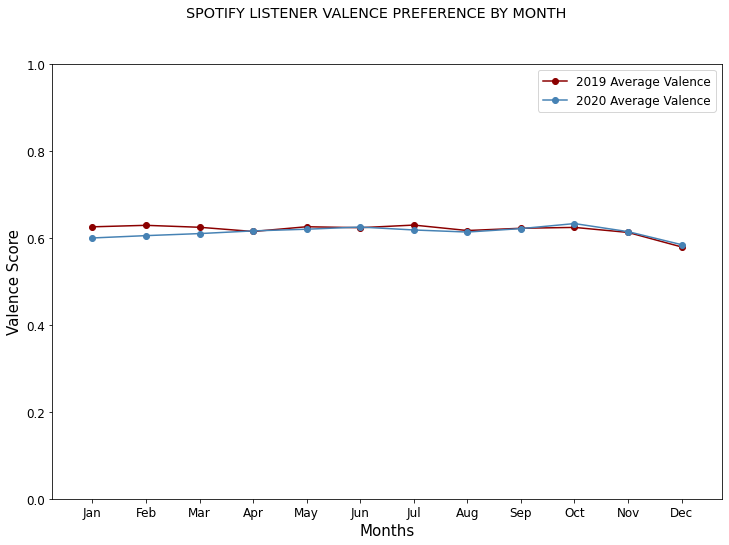

In [15]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = pd.DataFrame(clean_global_ids_data_groupby[clean_global_ids_data_groupby['Year'] == 2019])

valence_2020 = pd.DataFrame(clean_global_ids_data_groupby[clean_global_ids_data_groupby['Year'] == 2020])
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH')         # Set up main title

y_axis = valence_2019['Valence']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence'], label="2019 Average Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence'], label="2020 Average Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [16]:
# Compare valence scores with covide infection rate

covid_dfs = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

covid_df = covid_dfs.sample(1000)

covid_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
30012,GHA,Africa,Ghana,2021-01-21,59480.0,1049.0,357.000,361.0,3.0,2.857,...,4227.630,12.0,298.245,4.97,0.3,7.7,41.047,0.900,64.07,0.611
38140,ITA,Europe,Italy,2021-01-09,2257866.0,19976.0,16666.429,78394.0,483.0,487.000,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.180,83.51,0.892
77282,TUN,Africa,Tunisia,2020-03-11,7.0,2.0,0.857,NaN,NaN,0.000,...,10849.297,2.0,318.991,8.52,1.1,65.8,78.687,2.300,76.70,0.740
56730,NOR,Europe,Norway,2020-11-15,28434.0,0.0,528.857,294.0,0.0,1.286,...,64800.057,0.2,114.316,5.31,19.6,20.7,NaN,3.600,82.40,0.957
45926,MWI,Africa,Malawi,2020-05-20,71.0,1.0,1.143,3.0,0.0,0.000,...,1095.042,71.4,227.349,3.94,4.4,24.7,8.704,1.300,64.26,0.483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60740,PHL,Asia,Philippines,2021-03-11,607048.0,3740.0,3197.286,12608.0,63.0,29.143,...,7599.188,NaN,370.437,7.07,7.8,40.8,78.463,1.000,71.23,0.718
66859,SRB,Europe,Serbia,2021-04-20,667937.0,2965.0,2741.714,6058.0,32.0,35.714,...,14048.881,NaN,439.415,10.08,37.7,40.2,97.719,5.609,76.00,0.806
33618,HND,North America,Honduras,2021-02-19,164077.0,772.0,721.857,3975.0,10.0,18.143,...,4541.795,16.0,240.208,7.21,2.0,NaN,84.169,0.700,75.27,0.634
82129,VEN,South America,Venezuela,2021-02-16,133927.0,350.0,404.429,1292.0,7.0,6.429,...,16745.022,NaN,204.850,6.47,NaN,NaN,NaN,0.800,72.06,0.711


In [17]:
# Filter data for 2020, and add a 'month' column
covid_2020_df = pd.DataFrame(covid_df[covid_df.date.str.contains(r'2020.*')])
covid_2020_df['Month'] = ''
covid_2020_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
77282,TUN,Africa,Tunisia,2020-03-11,7.0,2.0,0.857,NaN,NaN,0.000,...,2.0,318.991,8.52,1.1,65.8,78.687,2.3,76.70,0.740,
56730,NOR,Europe,Norway,2020-11-15,28434.0,0.0,528.857,294.0,0.0,1.286,...,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.40,0.957,
45926,MWI,Africa,Malawi,2020-05-20,71.0,1.0,1.143,3.0,0.0,0.000,...,71.4,227.349,3.94,4.4,24.7,8.704,1.3,64.26,0.483,
1741,AND,Europe,Andorra,2020-03-22,113.0,25.0,16.000,1.0,1.0,0.143,...,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868,
80481,URY,South America,Uruguay,2020-06-15,848.0,0.0,0.429,23.0,0.0,0.000,...,0.1,160.708,6.93,14.0,19.9,NaN,2.8,77.91,0.817,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48006,MHL,Oceania,Marshall Islands,2020-11-18,4.0,0.0,0.429,NaN,NaN,0.000,...,NaN,557.793,30.53,NaN,NaN,82.502,2.7,73.70,0.704,
19435,CYP,Europe,Cyprus,2020-07-07,1005.0,1.0,1.000,19.0,0.0,0.000,...,NaN,141.171,9.24,19.6,52.7,NaN,3.4,80.98,0.887,
40183,KEN,Africa,Kenya,2020-07-31,20636.0,723.0,624.000,341.0,16.0,9.571,...,36.8,218.637,2.92,1.2,20.4,24.651,1.4,66.70,0.601,
75884,THA,Asia,Thailand,2020-11-19,3892.0,4.0,4.429,60.0,0.0,0.000,...,0.1,109.861,7.04,1.9,38.8,90.670,2.1,77.15,0.777,


In [24]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later
for index, row in covid_2020_df.iterrows():
    month = re.findall(f"2020-(\d\d)-", row['date'])
    try:
        covid_2020_df.loc[index, 'Month'] = int(month[0])
    except:
        covid_2020_df.loc[index, 'Month'] = ""
covid_2020df = pd.DataFrame(covid_2020_df)
covid_2020df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
77282,TUN,Africa,Tunisia,2020-03-11,7.0,2.0,0.857,NaN,NaN,0.000,...,2.0,318.991,8.52,1.1,65.8,78.687,2.3,76.70,0.740,3
56730,NOR,Europe,Norway,2020-11-15,28434.0,0.0,528.857,294.0,0.0,1.286,...,0.2,114.316,5.31,19.6,20.7,NaN,3.6,82.40,0.957,11
45926,MWI,Africa,Malawi,2020-05-20,71.0,1.0,1.143,3.0,0.0,0.000,...,71.4,227.349,3.94,4.4,24.7,8.704,1.3,64.26,0.483,5
1741,AND,Europe,Andorra,2020-03-22,113.0,25.0,16.000,1.0,1.0,0.143,...,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868,3
80481,URY,South America,Uruguay,2020-06-15,848.0,0.0,0.429,23.0,0.0,0.000,...,0.1,160.708,6.93,14.0,19.9,NaN,2.8,77.91,0.817,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48006,MHL,Oceania,Marshall Islands,2020-11-18,4.0,0.0,0.429,NaN,NaN,0.000,...,NaN,557.793,30.53,NaN,NaN,82.502,2.7,73.70,0.704,11
19435,CYP,Europe,Cyprus,2020-07-07,1005.0,1.0,1.000,19.0,0.0,0.000,...,NaN,141.171,9.24,19.6,52.7,NaN,3.4,80.98,0.887,7
40183,KEN,Africa,Kenya,2020-07-31,20636.0,723.0,624.000,341.0,16.0,9.571,...,36.8,218.637,2.92,1.2,20.4,24.651,1.4,66.70,0.601,7
75884,THA,Asia,Thailand,2020-11-19,3892.0,4.0,4.429,60.0,0.0,0.000,...,0.1,109.861,7.04,1.9,38.8,90.670,2.1,77.15,0.777,11


In [25]:
# Create a groupby to get the sum of new cases in each month
covid_df_2020_groupby = pd.DataFrame(covid_2020df.groupby(['Month'], as_index=False)['new_cases'].sum())
covid_df_2020_groupby

,Month,new_cases
0,1,7.0
1,2,3749.0
2,3,12598.0
3,4,202078.0
4,5,103032.0
5,6,88423.0
6,7,373005.0
7,8,312474.0
8,9,331628.0
9,10,291966.0


In [29]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

covid_valence_df = pd.merge(valence_2020, covid_df_2020_groupby, on="Month")
covid_valence_df = covid_valence_df.rename(columns={"new_cases":"New Cases"})
covid_valence_df

,Month,Valence,New Cases
0,1,0.599790,7.0
1,2,0.605140,3749.0
2,3,0.609845,12598.0
3,4,0.616030,202078.0
4,5,0.619910,103032.0
5,6,0.624930,88423.0
6,7,0.618166,373005.0
7,8,0.613389,312474.0
8,9,0.621278,331628.0
9,10,0.632869,291966.0


In [30]:
# Add a new cases per million column

population = 7000000000 
covid_valence_df['New Cases Per Million'] = covid_valence_df['New Cases'] / country_polulation *1000000
covid_valence_df

,Month,Valence,New Cases,New Cases Per Million
0,1,0.599790,7.0,1.399412
1,2,0.605140,3749.0,749.485216
2,3,0.609845,12598.0,2518.542212
3,4,0.616030,202078.0,40398.632574
4,5,0.619910,103032.0,20597.748945
5,6,0.624930,88423.0,17677.175586
6,7,0.618166,373005.0,74569.680734
7,8,0.613389,312474.0,62468.563203
8,9,0.621278,331628.0,66297.754943
9,10,0.632869,291966.0,58368.685152


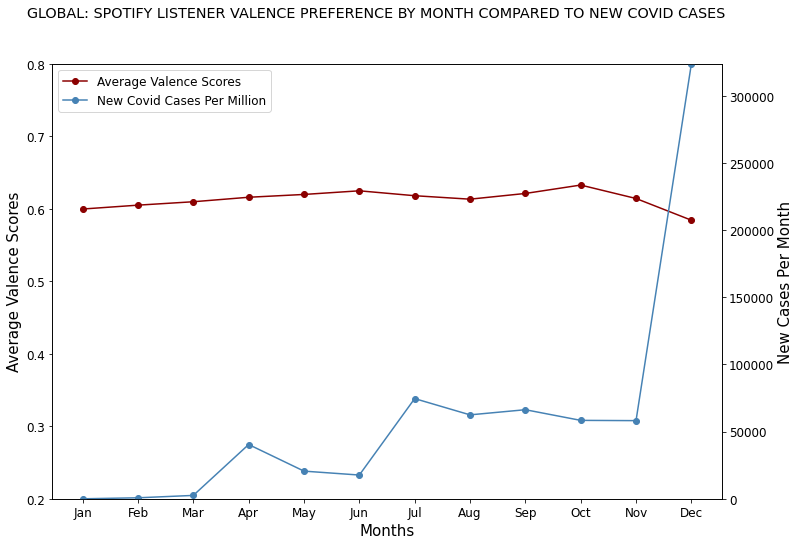

In [32]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('GLOBAL: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = covid_valence_df['Valence']
ax1.plot(months, ax1_ydata, label="Average Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [33]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot
def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

In [1]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = covid_valence_df['Valence']                                 # Set up axes
y_axis = covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('GLOBAL: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"Valence")                                               # Set x axis label for subplot                  
plt.ylabel(f"New Covid Cases")                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()

NameError: name 'covid_valence_df' is not defined